In [2]:
from rlbirdv2 import *
from ple import PLE
from IPython.display import Image
import imageio
import mdptoolbox
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Flatten, Dense, Activation
from keras.optimizers import Adam
from keras import backend as kerasBackend
from ple import PLE
import pickle

x = [i for i in range(3)]
y = [i for i in range(3)]
y.reverse()

# List of coordinates for islands
island = [(0, 0)]
birdStart = (0, 0)

TILESIZE = 40
SCREEN_WIDTH = TILESIZE*(len(x)+3)
SCREEN_HEIGHT = TILESIZE * len(y)

reward = {'win' : 1,
         'lose' : 0}

# import specific Game -------------------------
file = open("../RLv1/fish2",'rb')
fish = pickle.load(file)
# ----------------------------------------------

# run.py
pygame.init()
game = RLBird(width = SCREEN_WIDTH, height = SCREEN_HEIGHT, x = x, y = y,\
              init_bird_position = birdStart, island_position = island, \
              energyMax = 25, catchMax = 2, costMove = -2, costDive = -3, factorFishFly = 0.25,\
              reward = reward)
game.init()
game.updateFishMap(fish.copy())

### Human Policy 

In [3]:
pygame.init()
p = PLE(game, fps=100, frame_skip=1, num_steps=1, force_fps=True, display_screen=True, reward_values = reward)

p.init()
p.reset_game()
game.updateFishMap(fish.copy())

dt = 0
while(not p.game_over()):
        game.step(dt)
        pygame.display.update()
        dt += 1
print(game.getScore())
pygame.quit()

1


In [4]:
fish

array([[0.        , 0.01552608, 0.30287186],
       [0.1562188 , 0.25212845, 0.3765251 ],
       [0.26855578, 0.52494901, 0.43451012]])

### Q-Learning : An agent-based approach


In [4]:
import timeit

COMPUTE_NEW_POLICY = False

# Epsilon
INITIAL_EXPLORATION = 5000
EXPLORATION_STEPS   = 30000
INITIAL_EPSILON     = 1
FINAL_EPSILON       = 1e-2

# Constants
GAMMA        = 0.99
ALPHA        = 0.01
NUMBER_GAMES = 50000

INTERMEDIATE_SCORE = 500

# Epsilon
LEARNING_RATE = 0.01

def epsilon(step):
    """
    Epsilon for exploration/exploitation trade-off
    """
    if step < INITIAL_EXPLORATION:
        return 1
    elif step < EXPLORATION_STEPS:
        return INITIAL_EPSILON + (FINAL_EPSILON - INITIAL_EPSILON)/(EXPLORATION_STEPS-INITIAL_EXPLORATION) * (step-INITIAL_EXPLORATION)
    else:
        return FINAL_EPSILON
    
# Epsilon greedy algorithm for exploring state-space (movement only)
def epsilon_greedy(game, Q, k, state):
    
    idx = game.listStates.state2idx(state)
    a = np.argmax(Q[idx][:])
    
    if(np.random.rand()<=epsilon(k)):                       # other random action
            la = [i for i in range(len(game.listAction))]
            la.remove(a)
            a = np.random.choice(la)
    return a

In [5]:
# Q-learning
if COMPUTE_NEW_POLICY:
    Q = np.zeros((game.listBirdStates.size, len(game.listAction))) # to track update frequencies
    count = np.zeros((game.listBirdStates.size, len(game.listAction))) # to track update frequencies
else :
    file = open("Qlearning_bird",'rb')
    Q = pickle.load(file)
    count = np.zeros((game.listBirdStates.size, len(game.listAction))) # to track update frequencies

In [8]:
score = np.zeros(INTERMEDIATE_SCORE)
SCORE = np.zeros(int(NUMBER_GAMES/INTERMEDIATE_SCORE))

time_start = timeit.default_timer()

kk =0
kkk = 0
for k in range(NUMBER_GAMES):
    if((k+1)%INTERMEDIATE_SCORE==0):
        print('Mean Score after ', k+1, ' Games : ', np.mean(score))
        kk = 0 
        SCORE[kkk] = np.mean(score)
        kkk += 1
    p.init()
    p.reset_game()
    game.updateFishMap(fish.copy())
    reward = 0.0
    
    while(not p.game_over()):
        state = game.getBirdState()
        x = game.listBirdStates.state2idx(state)
        a = epsilon_greedy(game, Q, k, state)
        reward = p.act(game.dictAction[game.listAction[a]])
        
        state_new = game.getBirdState()
        x_new = game.listBirdStates.state2idx(state_new)

        Q[x][a] = Q[x][a] + ALPHA * (reward+GAMMA*np.max(Q[x_new][:])-Q[x][a])
        count[x][a] += 1
        
    score[kk] = game.getScore()
    kk += 1
pygame.quit()


# save specific Policy -------------------------
with open('Qlearning_bird', 'wb') as f:
    pickle.dump(Q,f)
    
time_end = timeit.default_timer()

Mean Score after  500  Games :  0.006
Mean Score after  1000  Games :  0.006
Mean Score after  1500  Games :  0.004
Mean Score after  2000  Games :  0.0
Mean Score after  2500  Games :  0.004
Mean Score after  3000  Games :  0.0
Mean Score after  3500  Games :  0.0
Mean Score after  4000  Games :  0.0
Mean Score after  4500  Games :  0.0
Mean Score after  5000  Games :  0.0
Mean Score after  5500  Games :  0.01
Mean Score after  6000  Games :  0.002
Mean Score after  6500  Games :  0.002
Mean Score after  7000  Games :  0.012
Mean Score after  7500  Games :  0.026
Mean Score after  8000  Games :  0.016
Mean Score after  8500  Games :  0.024
Mean Score after  9000  Games :  0.012
Mean Score after  9500  Games :  0.03
Mean Score after  10000  Games :  0.028
Mean Score after  10500  Games :  0.042
Mean Score after  11000  Games :  0.04
Mean Score after  11500  Games :  0.056
Mean Score after  12000  Games :  0.036
Mean Score after  12500  Games :  0.05
Mean Score after  13000  Games :  0.

KeyboardInterrupt: 

In [9]:
# save specific Policy -------------------------
with open('Qlearning_bird', 'wb') as f:
    pickle.dump(Q,f)

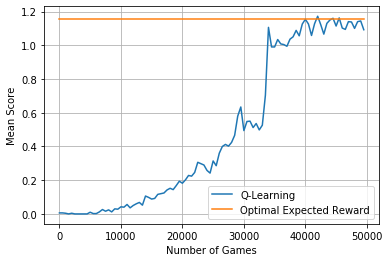

In [26]:
import matplotlib.pyplot as plt

x = [INTERMEDIATE_SCORE * i for i in range(len(SCORE))]
SCORE

plt.plot(x[0:100], SCORE[0:100], label = 'Q-Learning')
plt.plot(x[0:100], 1.158*np.ones(100), label = 'Optimal Expected Reward')
plt.grid()
plt.legend()
plt.xlabel('Number of Games')
plt.ylabel('Mean Score')
plt.show()

In [23]:
np.sum(count >0)/count.size

0.5743589743589743

In [ ]:
print((time_end - time_start)/3600, 'hours')

In [20]:
## View current policy
p.init()
p.reset_game()
game.updateFishMap(fish.copy())

images = []
dt = 0
while(not p.game_over()):
    state = game.getBirdState()
    idx = game.listBirdStates.state2idx(state)
    a = np.argmax(Q[idx][:])
    reward = p.act(game.dictAction[game.listAction[a]])
    
    pic = './results/screenshot'+str(dt)+'.jpeg'
    pygame.image.save(game.screen, pic)
    images.append(imageio.imread(pic))

    dt +=1
    
imageio.mimsave('./results/RL_Bird.gif', images)
pygame.quit()

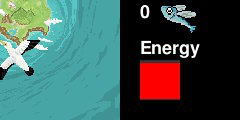

In [21]:
with open('./results/RL_Bird.gif','rb') as file:
    display(Image(file.read()))